In [6]:
import pandas as pd
import numpy as np

In [15]:
df = pd.read_csv('reviews.csv')
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ProductId               10000 non-null  object
 1   UserId                  10000 non-null  object
 2   ProfileName             10000 non-null  object
 3   HelpfulnessNumerator    10000 non-null  int64 
 4   HelpfulnessDenominator  10000 non-null  int64 
 5   Score                   10000 non-null  int64 
 6   Time                    10000 non-null  int64 
 7   Summary                 10000 non-null  object
 8   Text                    10000 non-null  object
dtypes: int64(4), object(5)
memory usage: 703.2+ KB


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
# NLP Packages
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords

In [160]:
import re
from bs4 import BeautifulSoup
import pickle

In [68]:
# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [22]:
# null values
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## Basic EDA

In [23]:
# words per review
words_per_review = df['Text'].apply(lambda x: len(x.split(' ')))

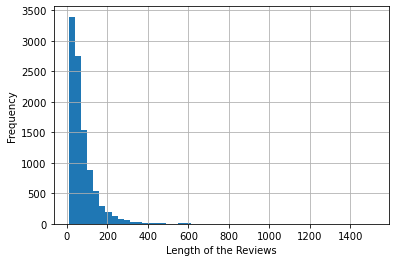

In [26]:
words_per_review.hist(bins=50)
plt.xlabel('Length of the Reviews')
plt.ylabel('Frequency')
plt.show()

In [27]:
print('Average words per review ', words_per_review.mean())
print('skewness ', words_per_review.skew())

Average words per review  77.9028
skewness  4.612459483340116


In [28]:
# distribution of ratings across reviews
ratings = (df['Score'].value_counts()/len(df))*100
ratings

5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: Score, dtype: float64

<AxesSubplot:>

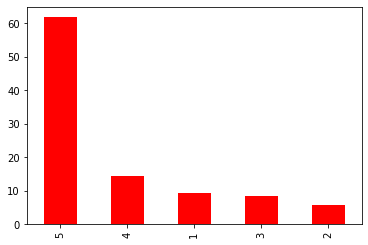

In [29]:
ratings.plot.bar(color='red')

### Observation
- Too many 5 ratings and than other ratings
- max review length is between 0 to 500 words

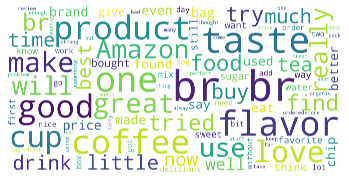

In [30]:

word_cloud_text = ''.join(df['Text'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

## Data Cleaning

In [31]:
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

### Observation
- Since we are more concerned with the text, and score, which dont have null we will not drop NaN values here

### mapping of score
- we want to say positive review for score 4 and 5
- and score 1 and 2 as negative
- score 3 is neutral, so we will drop those values

In [32]:
df['sentiment'] = np.where(df['Score']>3, 1, 0)
df['sentiment'].head()

0    1
1    0
2    1
3    0
4    1
Name: sentiment, dtype: int32

In [33]:
df.shape

(10000, 10)

In [34]:
df = df[df['Score'] != 3]
df.shape

(9138, 10)

we just dropped all the neutral values ie.[](http://) score=3

<AxesSubplot:>

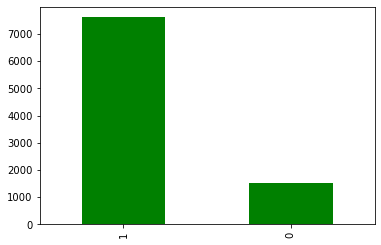

In [35]:
df['sentiment'].value_counts().plot.bar(color='green')

### Observation
- too many positive reviews
- data is imbalanced


## Text Preprocessing
- converting to lower case
- removing html tags
- removing special characters
- remove words which have numbers in them
- Removing stop words
- stemming and lemmatization

In [36]:
# converting to lower case
df['Text'] = df['Text'].str.lower()
df['Text'].head()

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price.  there was a wid...
Name: Text, dtype: object

In [37]:
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python/40823105#40823105
def remove_URL(text):
    """Remove URLs from a text string"""
    return re.sub(r"http\S+", "", text)

In [38]:
# removing any urls from the review text
df['Text'] = df['Text'].apply(lambda x: remove_URL(x))
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price. there was a wid...,1


In [43]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
def getText(x):
    # soup = BeautifulSoup(x, 'lxml')
    soup = BeautifulSoup(x)
    text = soup.get_text()
    return text

In [44]:
# removing any tags present
df['Text'] = df['Text'].apply(lambda x: getText(x))
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price. there was a wid...,1


In [45]:
# removing special characters
def remove_spl(x):
    x = re.sub('[^A-Za-z0-9]+', ' ', x)
    return x

In [46]:
# removing special characters from the review text
df['Text'] = df['Text'].apply(lambda x: remove_spl(x))
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price there was a wide ...,1


In [47]:
df.iloc[0].Text

'i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most '

#### remove words which have numbers in them
eg: amazi646g hello46747**

In [48]:
def remove_num_words(x):
    x = re.sub('\w*\d\w*', ' ', x)
    return x

In [49]:
# removing words having numbers in them
df['Text'] = df['Text'].apply(lambda x: remove_num_words(x))
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price there was a wide ...,1


#### lets pickle the cleaned data before proceeding and applying word tokenizer
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_pickle.html

In [50]:
df.to_pickle('data_clean.pkl')

In [43]:
df = pd.read_pickle('data_clean.pkl')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,i have bought several of the vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled as jumbo salted peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",this is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,if you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy at a great price there was a wide ...,1


#### Removing stop words
- https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

In [51]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

print(stopwords.fileids())

['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VikasKM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'me', "doesn't", 'where', 'of', 'too', 'ours', 'couldn', 'itself', "aren't", 'we', 'him', 'theirs', 'under', "shouldn't", 's', 'o', 'no', 'doesn', 'out', 'because', 'more', 'then', 'does', 'he', 'don', 'myself', 'what', 'be', 'again', 'all', 'such', "didn't", 'mightn', 'are', 'during', 'the', 'against', 'each', "isn't", "mightn't", 'for', 'into', 'your', 'have', 'nor', "wasn't", 'off', 'how', 'you', 'mustn', 'any', 'hadn', 'this', 'about', 'those', "she's", 'which', 'shouldn', 'to', 'wouldn', 'won', 'down', 'than', 'needn', 'they', 've', "weren't", 'between', 'i', 'it', 'do', 'there', 'or', 'doing', 'my', 'both', 'themselves', 'ain', 'were', 'an', 'above', 'why', 'himself', "should've", 'was', 'whom', "it's", 'their', "you're", 'a', 'its', "needn't", 'further', 'her', 'most', 'aren', 'y', 'having', 'being', 'over', 'once', 'herself', 'haven', 'before', 'after', "mustn't", 'own', "shan't", "don't", 'will', "hadn't", 're', 'yourself', 'as', 'she', 'shan', "wouldn't", "that'll", 'yours',

In [53]:
# sentence = df['Text'].iloc[0]
# print(sentence)
# print(50*'-')
# from nltk.tokenize import word_tokenize  
# word_tokens = word_tokenize(sentence)  
# print(word_tokens)
# print(50*'-')
# filtered_sentence = [w for w in word_tokens if w not in stop_words]
# print(filtered_sentence)

In [54]:
# removing stop words from the review text
def remove_stop_words(x, stop_words):
    text = ' '.join(word for word in word_tokenize(x) if word not in stop_words)
    return text
    

In [55]:
# text = 'i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most'
# t = remove_stop_words(text, stop_words)
# t

In [56]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

df['Text'] = df['Text'].apply(lambda x: remove_stop_words(x, stop_words))
df['Text'].iloc[0]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VikasKM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VikasKM\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


'bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

#### Above steps taking a lot of time, time to save the data in another pickle file


In [57]:
df.to_pickle('data_removed_stop_words.pkl')

In [112]:
df_temp = pd.read_pickle('data_removed_stop_words.pkl')
df_temp.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought several vitality canned dog food produc...,1
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanuts p...,0
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",confection around centuries light pillowy citr...,1
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe f...,0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price wide assortment yummy ...,1


## Stemming and Lemmatization
- https://www.tutorialspoint.com/python_text_processing/python_stemming_algorithms.htm
- https://www.tutorialspoint.com/python_text_processing/python_wordnet_interface.htm

In [58]:
import nltk
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

In [59]:
word_data = "Aging head of famous crime family decides to transfer his position to one of his subalterns" 
nltk_tokens = nltk.word_tokenize(word_data)
for w_port in nltk_tokens:
   print("Actual: %s  || Stem: %s"  % (w_port,porter_stemmer.stem(w_port)))

Actual: Aging  || Stem: age
Actual: head  || Stem: head
Actual: of  || Stem: of
Actual: famous  || Stem: famou
Actual: crime  || Stem: crime
Actual: family  || Stem: famili
Actual: decides  || Stem: decid
Actual: to  || Stem: to
Actual: transfer  || Stem: transfer
Actual: his  || Stem: hi
Actual: position  || Stem: posit
Actual: to  || Stem: to
Actual: one  || Stem: one
Actual: of  || Stem: of
Actual: his  || Stem: hi
Actual: subalterns  || Stem: subaltern


In [60]:
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\VikasKM\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [61]:
# Provide a word to be lemmatized
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

WordNet Lemmatizer
trouble
trouble
trouble


In [62]:
# n-grams
from nltk import ngrams

sentence = 'A bird in the hand worths two in the bush'

for n in range(1, 6):
    print(str(n) + '-grams:\n', list(ngrams(sentence.split(), n)))

1-grams:
 [('A',), ('bird',), ('in',), ('the',), ('hand',), ('worths',), ('two',), ('in',), ('the',), ('bush',)]
2-grams:
 [('A', 'bird'), ('bird', 'in'), ('in', 'the'), ('the', 'hand'), ('hand', 'worths'), ('worths', 'two'), ('two', 'in'), ('in', 'the'), ('the', 'bush')]
3-grams:
 [('A', 'bird', 'in'), ('bird', 'in', 'the'), ('in', 'the', 'hand'), ('the', 'hand', 'worths'), ('hand', 'worths', 'two'), ('worths', 'two', 'in'), ('two', 'in', 'the'), ('in', 'the', 'bush')]
4-grams:
 [('A', 'bird', 'in', 'the'), ('bird', 'in', 'the', 'hand'), ('in', 'the', 'hand', 'worths'), ('the', 'hand', 'worths', 'two'), ('hand', 'worths', 'two', 'in'), ('worths', 'two', 'in', 'the'), ('two', 'in', 'the', 'bush')]
5-grams:
 [('A', 'bird', 'in', 'the', 'hand'), ('bird', 'in', 'the', 'hand', 'worths'), ('in', 'the', 'hand', 'worths', 'two'), ('the', 'hand', 'worths', 'two', 'in'), ('hand', 'worths', 'two', 'in', 'the'), ('worths', 'two', 'in', 'the', 'bush')]


### Applying Bag of words

In [148]:
vec = CountVectorizer()
X = vec.fit_transform(df['Text'])
df_vec = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df_vec.head()

,aa,aaaa,aahhhs,ab,aback,abandon,abates,abberline,abbott,abby,...,zomg,zon,zoo,zoom,zotz,zucchini,zuke,zukes,zupas,zuppa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
### Creating a python object of the class CountVectorizer

bow_counts = CountVectorizer(tokenizer= word_tokenize,stop_words=stop_words, ngram_range=(1,1))

bow_data = bow_counts.fit_transform(df['Text'])

# Save the vectorizer
vec_file = 'bow_counts.pickle'
pickle.dump(bow_counts, open(vec_file, 'wb'))

In [150]:
bow_data

<9138x17479 sparse matrix of type '<class 'numpy.int64'>'
	with 285882 stored elements in Compressed Sparse Row format>

#### After bag of words is prepared, 
#### the dataset will be divided into training and test sets:

In [151]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, df['sentiment'], test_size = 0.3, random_state = 42)

In [152]:
y_test_bow.value_counts()

1    2304
0     438
Name: sentiment, dtype: int64

### Observations
- This data is highly imbalanced
- Need to apply oversampling or undersampling or SMOTE techniques

### Observations
- https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

### Applying Logistic Regression

In [153]:
lr_bow = LogisticRegression()
lr_bow.fit(X_train_bow, y_train_bow)

test_pred_lr_bow = lr_bow.predict(X_test_bow)

# Save the model
mod_file = 'lr_bow.model'
pickle.dump(lr_bow, open(mod_file, 'wb'))

## Calculate key performance metrics
print("F1 score: ", f1_score(y_test_bow, test_pred_lr_bow))

F1 score:  0.9410267288926603


### NGRAM changing from 1 to 4, to check if score increases

In [97]:
# bow_counts_more = CountVectorizer(tokenizer= word_tokenize, stop_words=stop_words, ngram_range=(1,4))

# bow_data_more = bow_counts_more.fit_transform(df.Text)

In [98]:
# bow_data_more

<9138x810334 sparse matrix of type '<class 'numpy.int64'>'
	with 1228826 stored elements in Compressed Sparse Row format>

In [99]:
# X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data_more, df['sentiment'], test_size = 0.3, random_state = 42)

In [100]:
# lr_bow_more = LogisticRegression()
# lr_bow_more.fit(X_train_bow, y_train_bow)

# test_pred_lr_bow_more = lr_bow_more.predict(X_test_bow)

# ## Calculate key performance metrics
# print("F1 score: ", f1_score(y_test_bow, test_pred_lr_bow_more))

F1 score:  0.9370225067107165


#### Observation
- F1 Score slightly decreased from 0.941026 to 0.937022

## Applying TFIDF

In [154]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize,stop_words=stop_words, ngram_range=(1,1))

tfidf_data = tfidf_counts.fit_transform(df['Text'])

# Save the vectorizer
vec_file = 'tfidf_counts.pickle'
pickle.dump(tfidf_counts, open(vec_file, 'wb'))

In [155]:
tfidf_data

<9138x17479 sparse matrix of type '<class 'numpy.float64'>'
	with 285882 stored elements in Compressed Sparse Row format>

In [156]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data, df['sentiment'], test_size = 0.3,random_state = 42)

### Applying Logistic Regression to TFIDF

In [157]:
lr_tf_idf = LogisticRegression()

lr_tf_idf.fit(X_train_tfidf,y_train_tfidf)

test_pred_lr_tf_idf = lr_tf_idf.predict(X_test_tfidf)

# Save the model
mod_file = 'lr_tf_idf.model'
pickle.dump(lr_tf_idf, open(mod_file, 'wb'))

## Evaluating the model
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_tf_idf))

F1 score:  0.9292071197411004


## testing the pickle files

In [159]:
text='this is fantastic book love it'
loaded_vectorizer = pickle.load(open('bow_counts.pickle', 'rb'))

# load the model
loaded_model = pickle.load(open('lr_bow.model', 'rb'))

# make a prediction
print(loaded_model.predict(loaded_vectorizer.transform([text])))

[1]


## testing the pickle files

In [162]:
text='this is fantastic book love it'
loaded_vectorizer = pickle.load(open('tfidf_counts.pickle', 'rb'))

# load the model
loaded_model = pickle.load(open('lr_tf_idf.model', 'rb'))

# make a prediction
print(loaded_model.predict(loaded_vectorizer.transform([text])))

[1]


In [169]:
def predictText(text):
    lrbow = -1
    lrtfidf = -1

    #load vectorizer
    loaded_bow = pickle.load(open('bow_counts.pickle', 'rb'))
    # load the model
    loaded_model_bow = pickle.load(open('lr_bow.model', 'rb'))
    # make a prediction
    lrbow = int(loaded_model_bow.predict(loaded_bow.transform([text])))

    # load vectorizer
    loaded_tfidf = pickle.load(open('tfidf_counts.pickle', 'rb'))
    # load the model
    loaded_model_tfidf = pickle.load(open('lr_tf_idf.model', 'rb'))

    # make a prediction
    lrtfidf = int(loaded_model_tfidf.predict(loaded_tfidf.transform([text])))

    return lrbow, lrtfidf


In [179]:
text='love'
lrbow, lrtfidf = predictText(text)
print(lrbow)
print(lrtfidf)

1
1
